# NN Train on MNIST digits

## import MNIST TRAINING 28x28 digits
CSV file each row is <category><pixels 0..783>

In [1]:
DATA_DIR = '../../Data/mnist/' # contains mnist_train.csv file

In [19]:
import math
import random
import numpy as np
import time
import keras
from tqdm import trange
from IPython.display import clear_output

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [3]:
def load_mnist():
    print('Loading MNIST training data...')
    file_data = np.loadtxt(DATA_DIR+'mnist_train.csv', delimiter = ',')
    print('Loaded MNIST training data, shape {0} dtype {1}'.format(file_data.shape, file_data.dtype))
    # extract first element (label) from each row of the data, and convert to one-hot 0..9
    labels = file_data[:,0].astype(int) # 1st element of each row is label
    print('labels.size {0}'.format(labels.size))
    one_hot_labels = np.zeros((labels.size, 10)) # initialize same length array with 10-element zero vectors
    one_hot_labels[np.arange(labels.size),labels] = 1 # set the n'th element of one-hot vector to 1 (n=label)
    # extract the digit pixels
    digits = file_data[:,1:] # remaining elements are 784-pixel vectors
    digits -= digits.min() # scale the data so values are between 0 and 1
    digits /= digits.max() # scale

    return (one_hot_labels, digits)

In [4]:
(data_labels,data_digits) = load_mnist()

Loading MNIST training data...
Loaded MNIST training data, shape (60000, 785) dtype float64
labels.size 60000


### Inspect the first digit
Categorized as '5', i.e. categories[0] = 5
digits[0] is a 784-element vector representing the 28x28 grayscale image

In [5]:
data_labels[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [6]:
print(data_labels.shape,data_labels.size)
print(data_digits.shape)

(60000, 10) 600000
(60000, 784)


[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


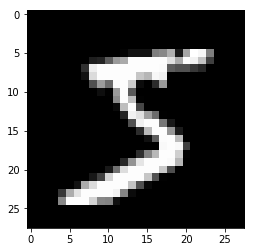

In [25]:
def print_digit(digit):
    test_digit = np.mat(digit).reshape(28,28)
    plt.imshow(test_digit, cmap='gray')
    plt.show()
    
print(data_labels[0])
print_digit( data_digits[0])

# NN

Print the max and min values of the pixels in all the digits

In [8]:
data_digits.max()

1.0

In [17]:
data_digits.min()

0.0

### Create simple 60,000 x 1 list zero_labels from 60,000 x 10 one-hot digit labels

In [31]:
zero_labels = data_labels[:,0]

print("zero_labels.shape",zero_labels.shape)

for i in [0,1,2,21,22]:
    print(i, data_labels[i], labels_zero[i])

zero_labels.shape (60000,)
0 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 0.0
1 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1.0
2 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 0.0
21 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1.0
22 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 0.0


## Define the CNN

We start by defining input layer n x 784, and a labels layer n x 10

In [27]:
IMAGE_SIZE_X = 28
IMAGE_SIZE_Y = 28
IMAGE_SIZE = IMAGE_SIZE_X * IMAGE_SIZE_Y
LABELS_SIZE = 10


In [28]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [21]:
def compute_loss(labels, outputs):
    m = labels.shape[0]
    return -(1/m) * ( np.sum( np.multiply(np.log(outputs),labels)) + 
                      np.sum( np.multiply(np.log(1-outputs),(1-labels))))


In [2]:
np.random.seed(42)

class Layer:
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        self.weights = np.zeros(shape=(input.shape[1], 10))
        bias = np.zeros(shape=(10,))
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, 10]
        """
        output = np.matmul(input, self.weights) + bias
        return output

In [3]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        return np.matmul(input, self.weights) + self.biases
      
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output,np.transpose(self.weights))

        # compute gradient w.r.t. weights and biases
        grad_weights = np.transpose(np.dot(np.transpose(grad_output),input))
        grad_biases = np.sum(grad_output, axis = 0)
        
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        return grad_input

In [4]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(0,input)

    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad 

In [5]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

In [6]:
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]
  

In [10]:
# Import Dataset

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

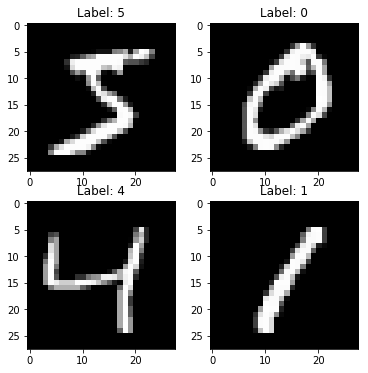

In [12]:
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');
    

In [13]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [14]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    for i in range(len(network)):
        activations.append(network[i].forward(X))
        X = network[i].forward(X)
        
    assert len(activations) == len(network)
    return activations

In [15]:
def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

In [16]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    for i in range(1, len(network)):
        loss_grad = network[len(network) - i].backward(layer_activations[len(network) - i - 1], loss_grad)
    
    return np.mean(loss)
  

In [17]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        

Epoch 24
Train accuracy: 0.90364
Val accuracy: 0.9094


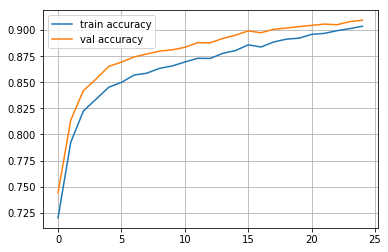

In [20]:
train_log = []
val_log = []
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Draw accuracy / time plot

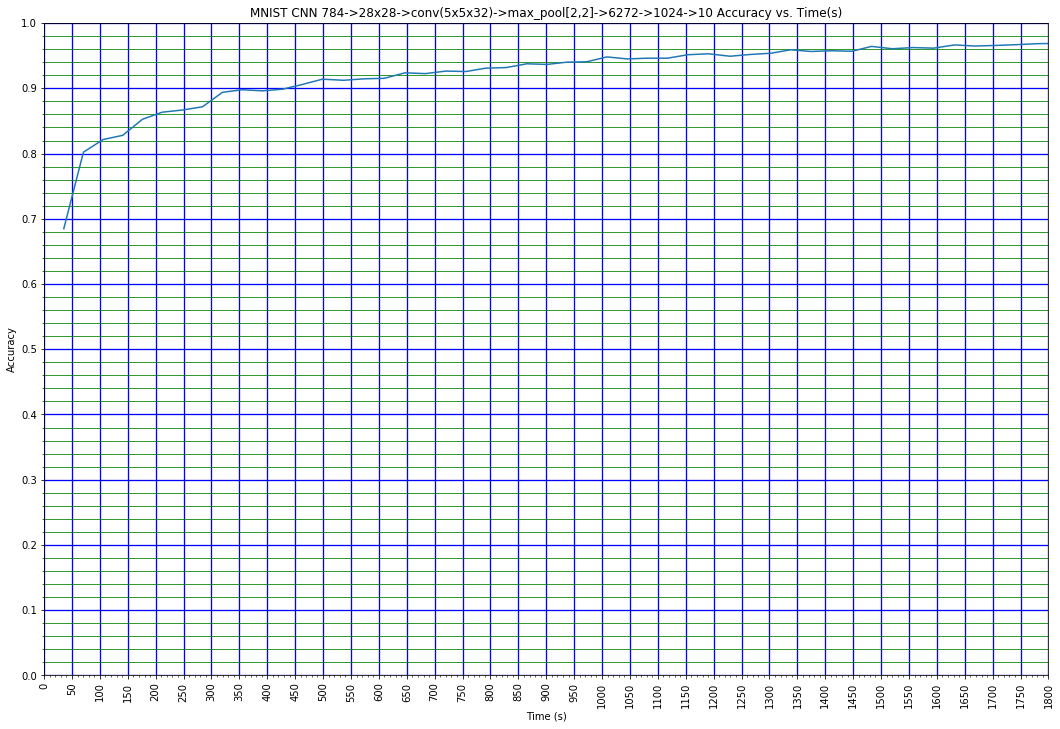

In [45]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(1, 1, 1)

ax.set_title("MNIST CNN 784->28x28->conv(5x5x32)->max_pool[2,2]->6272->1024->10 Accuracy vs. Time(s)", fontsize='large')

## Set up Time x axis

ax.set_xlabel("Time (s)")
# Min x axis value is 0 (so y-axis crosses at x=0)
ax.set_xlim(left=0)
# x ticks at 10s
ax.set_xticks(np.arange(0.0,max(graph_data_time),STEPS_COUNT))
ax.xaxis.grid(which='major', color='b', linewidth=1.3)

## Set up Accuracy y axis

ax.set_ylabel("Accuracy")
ax.set_ylim(bottom=0)
# Set Accuracy tick locations and define horizontal grid lines
minorLocator = MultipleLocator(0.05)
majorLocator = MultipleLocator(0.1)
ax.yaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.grid(which='major', color='b', linewidth=1.3)
ax.yaxis.grid(which='minor', color='g')

# Plot the chart
ax.plot(graph_data_time, graph_data_accuracy)

plt.minorticks_on()
plt.xticks(rotation=90)
plt.show(fig)